In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import logomaker as lm
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.misc import index_to_sample_df, downsample_raw_input, read_tRNAdb_info, sample_df_to_dict
from src.read_processing import AR_merge, BC_split, Kmer_analysis, BC_analysis, UMI_trim
from src.alignment import SWIPE_align
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.transcript_mutations import TM_analysis

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
seq_dir = 'raw_fastq'
seq_dir_noDS = seq_dir # Not downsampled

# These folder names are used in subsequent processing steps
# to dump data. Best to not change:
AdapterRemoval_dir = 'AdapterRemoval'
BC_dir = 'BC_split'
UMI_dir = 'UMI_trimmed'
align_dir = 'SWalign'
stats_dir = 'stats_collection'
TM_dir = 'transcript_mutations'
plotting_dir = 'plotting'
tRNA_database = dict()
tRNA_database['human'] = '{}/tRNA_database/human/hg38-tRNAs.fa'.format(homedir)
tRNA_database['mouse'] = '{}/tRNA_database/mouse/mm10-tRNAs.fa'.format(homedir)
# Read information (length, codon etc) of tRNAs into dictionary:
tRNA_data = read_tRNAdb_info(tRNA_database)
SWIPE_score_mat = '{}/utils/nuc_score-matrix.txt'.format(homedir)
SWIPE_score_mat2 = '{}/utils/nuc_score-matrix_2.txt'.format(homedir) # For masked reference sequences
# tRNA sequencing yields many duplicated reads.
# Adding these commonly seen sequences to a list prevents duplicated alignment:
common_seqs = '{}/utils/common-seqs.fasta.bz2'.format(homedir)

# Define minimum read length based on minimum insert size:
MIN_INSERT_LEN = 20
UMI_LEN = 10
BC_MAX_LEN = 19
MIN_READ_LEN = MIN_INSERT_LEN + UMI_LEN + BC_MAX_LEN
print('Using minimum read length: {} (after merge)'.format(MIN_READ_LEN))

# The minimum alignment score.
# The alignment score is calculated as 1 per match,
# -2 per mismatch, -6 per gap opening and -1 per gap extension.
# Better to set relatively low, since additional filtering can
# be applied later.
MIN_SCORE_ALIGN = 20
print('Using minimum alignemnt score: {}'.format(MIN_SCORE_ALIGN))

# Read index information:
index_list_fnam = 'index_list.xlsx'
index_df = pd.read_excel('{}/utils/{}'.format(homedir, index_list_fnam))

Notebook is in: /home/sulab/tRNA-charge-seq/projects/tRNAseq_third-gen
Repo is in: /home/sulab/tRNA-charge-seq
Using minimum read length: 49 (after merge)
Using minimum alignemnt score: 20


### Settings

In [3]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Add barcode sequences:
sample_df = index_to_sample_df(sample_df, index_df)
# Read elementary info (replicate, barcode, species)
# for each unique sample name into a dictionary:
sample_dict = sample_df_to_dict(sample_df)
# Get filenames from the sample information:
inp_file_df = sample_df[['fastq_mate1_filename', 'fastq_mate2_filename', 'P5_index', 'P7_index', 'P5_index_seq', 'P7_index_seq']].copy().drop_duplicates().reset_index(drop=True)

# Downsample:
if False:
    sample_df, inp_file_df, seq_dir = downsample_raw_input(sample_df, inp_file_df, NBdir, data_dir, seq_dir_noDS, downsample_absolute=1e4)

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                seq_dir = seq_dir,
                AdapterRemoval_dir = AdapterRemoval_dir,
                BC_dir = BC_dir,
                UMI_dir = UMI_dir,
                align_dir = align_dir,
                stats_dir = stats_dir,
                TM_dir = TM_dir,
                plotting_dir = plotting_dir)

In [4]:
# Run AdapterRemoval:
AR_obj = AR_merge(dir_dict, inp_file_df, MIN_READ_LEN)
AdapterRemoval_dir_abs = AR_obj.make_dir(overwrite=False)
inp_file_df = AR_obj.run_parallel(n_jobs=4, overwrite=False)

Using existing folder because overwrite set to false: /home/sulab/tRNA-charge-seq/projects/tRNAseq_third-gen/data/AdapterRemoval


In [5]:
# Split files based on barcodes:
BCsplit_obj = BC_split(dir_dict, sample_df, inp_file_df)
BC_dir_abs = BCsplit_obj.make_dir(overwrite=False)
sample_df, inp_file_df = BCsplit_obj.run_parallel(n_jobs=12, load_previous=True)

Using existing folder because overwrite set to false: /home/sulab/tRNA-charge-seq/projects/tRNAseq_third-gen/data/BC_split
Loaded results from previous run... Not running barcode split.


In [6]:
### Perform Kmer analysis on unmapped reads ###
if False: # barcode analysis is typically suficient 
    kmer_obj = Kmer_analysis(dir_dict, inp_file_df, index_df)
    # Add a filter to avoid Kmers from the end of tRNA sequences:
    kmer_obj.filter_3p_fasta(tRNA_database['human'])
    # Add to this filter the constant region of the adapters:
    kmer_obj.filter_window_BC(filter_window=(0, 11))
    # Search for Kmers:
    all_kmer = kmer_obj.search_unmapped(search_size=13)

In [7]:
if False:
    ### Perform barcode analysis on unmapped reads ###
    # Recall that adapters look like this:
    # GGCTGCCATGC    GACTA
    # GGCTGCCATGCA   AGTGC
    # GGCTGCCATGCTG  TCACG
    # GGCTGCCATGCAAC CTGAT
    # With the barcode as the rightmost 5 nt.
    # Search these 5 nt. barcodes by specifying BC_size_3p=5
    bc_analysis_obj = BC_analysis(dir_dict, inp_file_df, index_df, BC_size_3p=5, overwrite=True)
    # Search for barcodes in the unmapped reads.
    # For the summary output, filter by a max distance
    # to any barcode of 1 (group_dist=1), then group by barcode name:
    bc_analysis_df = bc_analysis_obj.search_unmapped(group_dist=1, overwrite=True)
    bc_analysis_df

In [8]:
### Generate UMI stats and write final trimmed tRNA sequences ###
# Note, the cDNA input amount is so large that it is very unlikely to sequence
# the same PCR amplified DNA twice. Therefore, this processing step does not
# attempt to merge possible UMI duplicates.
UMItrim_obj = UMI_trim(dir_dict, sample_df)
UMI_dir_abs = UMItrim_obj.make_dir(overwrite=False)
sample_df = UMItrim_obj.run_parallel(n_jobs=12, load_previous=True)
sample_df.head(3)

Using existing folder because overwrite set to false: /home/sulab/tRNA-charge-seq/projects/tRNAseq_third-gen/data/UMI_trimmed
Loaded results from previous run... Not running UMI trimming.


,sample_name_unique,sample_name,replicate,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp
0,100p1,100p,1,P1_R1.fastq.bz2,P1_R2.fastq.bz2,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,4616538,209482,4378444,4587926,99.380228,95.434059,4541029,513914,524197.217847,98.364380,98.038292
1,100p2,100p,2,P2_R1.fastq.bz2,P2_R2.fastq.bz2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,4681630,164567,4492025,4656592,99.465186,96.465935,4609801,511891,524208.378002,98.465727,97.650290
2,100p3,100p,3,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,2815593,139167,2656062,2795229,99.276742,95.021267,2768858,488028,521621.255089,98.340137,93.559838


In [9]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database, sample_df, SWIPE_score_mat, gap_penalty=6, extension_penalty=1, min_score_align=20, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=6, overwrite=False)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Using existing folder because overwrite set to false: /home/sulab/tRNA-charge-seq/projects/tRNAseq_third-gen/data/SWalign
Running Swipe on:  skipping:100p1  skipping:100p2  skipping:100p3  skipping:100p4  skipping:85p1  skipping:85p3  skipping:85p4  skipping:70p1  skipping:70p2  skipping:55p1  skipping:70p3  skipping:85p2  skipping:55p2  skipping:40p2  skipping:40p1  skipping:70p4  skipping:55p4  skipping:40p4  skipping:40p3  skipping:10p2  skipping:25p4  skipping:55p3  skipping:10p3  skipping:10p1  skipping:25p2  skipping:0p1  skipping:0p3  skipping:25p1  skipping:10p4  skipping:0p2  skipping:25p3  skipping:0p4  skipping:0p_90m4  skipping:0p_90m1  2h_1  4m_1  0p_90m2  8m_1  0p_90m3  0m_1  4h_1  8h_1  16h_1  1h_1  16m_1  40h_1  32m_1  4m_2  40h_NoOx_1  8m_2  0m_2  16m_2  32m_2  1h_2  4h_2  8h_2  0m_3  16h_2  2h_2  40h_2  4m_3  32m_3  1h_3  8m_3  4h_3  40h_NoOx_2  2h_3  16m_3  8h_3  40h_3  4m_4  40h_NoOx_3  16h_3  0m_4  8m_4  1h_4 

,sample_name_unique,sample_name,replicate,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,P1_R1.fastq.bz2,P1_R2.fastq.bz2,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,4616538,209482,4378444,4587926,99.380228,95.434059,4541029,513914,524197.217847,98.364380,98.038292,4501285.0,73.243329,26.756671,99.124780
1,100p2,100p,2,P2_R1.fastq.bz2,P2_R2.fastq.bz2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,4681630,164567,4492025,4656592,99.465186,96.465935,4609801,511891,524208.378002,98.465727,97.650290,4554502.0,74.554518,25.445482,98.800404
2,100p3,100p,3,P3_R1.fastq.bz2,P3_R2.fastq.bz2,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,2815593,139167,2656062,2795229,99.276742,95.021267,2768858,488028,521621.255089,98.340137,93.559838,2678606.0,72.047027,27.952973,96.740461


In [10]:
### Collect alignment statistics ###
stats_obj = STATS_collection(dir_dict, tRNA_data, sample_df, common_seqs=common_seqs)
stats_dir_abs = stats_obj.make_dir(overwrite=True)
stats_df = stats_obj.run_parallel(n_jobs=4)
# The dataframe returned is the "ALL_stats_aggregate_filtered.csv"
# which is the aggregated data filtered to contain only the
# most relevant columnns and requiring the 3' must be covered
# and have no 3' non-template bases.
# The CSV file output "ALL_stats_aggregate.csv" is the data
# aggregated based on all values identical except
# readID, 5p_UMI and 3p_BC. I.e. every information, except
# the UMI seequence is maintained in the aggregated CSV.
stats_df.head(3)

Using common sequences...

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,5p_cover,align_3p_nt,codon,anticodon,amino_acid,count
0,100p1,100p,1,l1Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,A,AAA,TTT,eColiLys,136
1,100p1,100p,1,l1Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,C,AAA,TTT,eColiLys,1219
2,100p1,100p,1,l1Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,True,A,AAA,TTT,eColiLys,67


In [11]:
### Generate standard tRNAseq data plots ###
plot_obj = TRNA_plot(dir_dict, sample_df, pull_default=True)
plotting_dir_abs = plot_obj.make_dir(overwrite=False)

# Plot UMI nucleotide content logo per sample:
#plot_obj.plot_UMI_logo()

# Plot the 5p non-template nucleotide logo per sample,
# using only those at, or below, the legth determined as a percentile:
#plot_obj.plot_non_temp('5p', '_5p-non-template_logo', seq_len_percentile=99)

# 3p non-template nucleotides are more rare, therefore 99.9 percentile:
#plot_obj.plot_non_temp('3p', '_3p-non-template_logo', seq_len_percentile=99.9)

# 3p non-template nucleotides, but require 3p coverage.
# This is more likely to reflect either:
# 1) Erronous CCA addition, or 2) additional bases in the adapter.
#plot_obj.plot_non_temp('3p', '_3p-non-template_3p-cover_logo', seq_len_percentile=99.9, _3p_cover=True)

# Plot the 5p to 3p coverage for each amino acid:
#plot_obj.plot_coverage(compartment='cyto', plot_type='needle', aa_norm=False, plot_name='cov_plot_cyto_needle')
#plot_obj.plot_coverage(compartment='mito', plot_type='needle', aa_norm=False, plot_name='cov_plot_mito_needle')
#plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', aa_norm=False, plot_name='cov_plot_cyto_behrens')
#plot_obj.plot_coverage(compartment='mito', plot_type='behrens', aa_norm=False, plot_name='cov_plot_mito_behrens')
#plot_obj.plot_coverage(compartment='cyto', plot_type='needle', aa_norm=False, #plot_name='cov_plot_cyto_needle_100p', sample_list=['100p1', '100p2', '100p3', '100p4'])
#plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', y_norm=True, plot_name='cov_plot_cyto_behrens_norm')



In [14]:
plot_obj.plot_UMI_logo(n_jobs=8)


Now collecting data for sample:  100p1  85p4  100p2  100p3  100p4  85p1  85p2  85p3  55p3  55p2  70p4  70p3  70p1  70p2  40p2  40p1  55p4  55p1  25p1  25p3  10p4  25p4  0p2  40p3  0p4  10p2  10p1  0p1  10p3  0p_90m2  0p_90m1  0p3  0p_90m3  25p2  1h_1  16m_1  40p4  0p_90m4  4m_1  0m_1  32m_1  2h_1  8h_1  4h_1  8m_1  4m_2  40h_1  16h_1  40h_NoOx_1  16m_2  0m_2  32m_2  1h_2  8m_2  0m_3  2h_2  4h_2  8h_2  40h_2  16h_2  40h_NoOx_2  4m_3  16m_3  8m_3  2h_3  32m_3  16h_3  1h_3  4m_4  8h_3  4h_3  40h_3  40h_NoOx_3  16m_4  0m_4  32m_4  8m_4  16h_4  1h_4  2h_4  8h_4  4h_4  40h_4  L1  L2  40h_NoOx_4  L7  L11  L4  L3  L8  L10  L6  L5  L9  R1  R2  R5  R3  R4  R6  L12  R12  R9  R7  R10  R11  R8
Now plotting logo plot.

In [15]:
plot_obj.plot_non_temp(end='5p', plot_name='_5p-non-template_logo', \
                       seq_len_percentile=99, n_jobs=8)


Now collecting data for sample:  100p1  100p3  100p2  100p4  85p3  85p4  70p1  85p1  85p2  55p1  70p3  70p2  70p4  55p2  40p2  40p1  55p4  40p3  40p4  25p2  25p4  10p1  55p3  25p1  25p3  0p1  10p2  10p3  0p3  0p_90m1  0p2  10p4  0p4  0p_90m3  0p_90m4  0m_1  0p_90m2  4m_1  32m_1  8m_1  16m_1  1h_1  4h_1  8h_1  2h_1  16h_1  0m_2  40h_1  4m_2  8m_2  40h_NoOx_1  16m_2  32m_2  1h_2  16h_2  2h_2  4h_2  8h_2  40h_NoOx_2  40h_2  0m_3  8m_3  4m_3  16m_3  32m_3  2h_3  8h_3  1h_3  4h_3  16h_3  40h_3  40h_NoOx_3  0m_4  16m_4  8m_4  1h_4  32m_4  4m_4  2h_4  8h_4  16h_4  4h_4  40h_4  L1  40h_NoOx_4  L2  L3  L5  L4  L6  L7  L11  L8  L10  L9  L12  R1  R2  R3  R4  R8  R6  R7  R11  R5  R9  R10  R12
Now plotting logo plot.
Now plotting logo plot.

In [16]:
plot_obj.plot_non_temp(end='3p', plot_name='_3p-non-template_logo', \
                       seq_len_percentile=99.9, n_jobs=8)


Now collecting data for sample:  100p1  100p2  100p4  100p3  85p1  85p2  85p3  85p4  55p3  70p3  55p2  70p4  70p1  70p2  40p1  55p1  40p3  55p4  10p1  25p1  25p3  0p1  10p3  25p4  0p4  40p4  10p2  0p_90m1  0p2  0p3  10p4  4m_1  25p2  32m_1  0p_90m2  40p2  0p_90m3  0m_1  4h_1  16m_1  8m_1  2h_1  0p_90m4  1h_1  8h_1  16h_1  4m_2  40h_1  40h_NoOx_1  0m_2  16m_2  2h_2  8m_2  1h_2  16h_2  32m_2  8h_2  40h_2  4m_3  4h_2  40h_NoOx_2  0m_3  2h_3  16m_3  1h_3  8m_3  16h_3  32m_3  4h_3  8h_3  16m_4  0m_4  2h_4  40h_NoOx_3  4m_4  40h_3  8m_4  4h_4  1h_4  32m_4  16h_4  40h_4  40h_NoOx_4  8h_4  L1  L5  L6  L7  L4  L12  L9  L8  L2  L3  L11  R1  R2  L10  R4  R6  R11  R5  R3  R7  R9  R10  R12  R8
Now plotting logo plot.
Now plotting logo plot.

In [17]:
plot_obj.plot_non_temp(end='3p', plot_name='_3p-non-template_3p-cover_logo', \
                       seq_len_percentile=99.9, _3p_cover=True, n_jobs=8)


Now collecting data for sample:  100p2  100p1  100p3  100p4  85p1  85p2  85p3  85p4  55p3  70p3  55p2  70p4  40p3  70p1  70p2  25p1  55p4  40p1  55p1  40p4  25p2  0p1  10p2  25p4  0p4  10p4  10p1  10p3  0p2  0p3  4m_1  0p_90m1  0p_90m3  40p2  25p3  2h_1  0p_90m2  4h_1  0m_1  0p_90m4  8m_1  1h_1  8h_1  16m_1  32m_1  16h_1  0m_2  40h_1  40h_NoOx_1  4m_2  16m_2  8m_2  2h_2  32m_2  1h_2  4h_2  40h_2  40h_NoOx_2  16h_2  8m_3  8h_2  0m_3  4m_3  1h_3  32m_3  16m_3  4h_3  2h_3  40h_3  16h_3  0m_4  8h_3  4m_4  40h_NoOx_3  2h_4  8m_4  32m_4  16m_4  4h_4  1h_4  L2  16h_4  8h_4  40h_NoOx_4  40h_4  L1  L5  L3  L8  L9  L6  L4  L7  L12  R5  L11  L10  R1  R3  R6  R4  R2  R7  R11  R9  R8  R12  R10
Now plotting logo plot.
Now plotting logo plot.

In [13]:
plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', y_norm=True, \
                       plot_name='cov_plot_cyto_behrens_norm', n_jobs=12)

plot_obj.plot_coverage(compartment='mito', plot_type='behrens', y_norm=True, \
                       plot_name='cov_plot_mito_behrens_norm', n_jobs=12)


Now collecting data for sample:  100p1  100p3  100p2  85p2  85p3  85p4  70p1  70p2  70p3  70p4  100p4  85p1  40p3  10p1  55p3  40p2  55p4  25p1  55p2  55p1  40p4  40p1  10p2  10p4  0p3  10p3  0m_1  25p4  16m_1  0p_90m1  0p_90m3  0p_90m2  0p2  0p1  25p2  40h_1  0p4  0p_90m4  32m_1  4m_1  4h_1  8m_1  25p3  2h_2  2h_1  16h_1  8h_1  0m_2  1h_1  8h_2  40h_NoOx_1  16m_2  8m_2  4h_2  32m_2  4m_2  1h_2  40h_NoOx_2  8h_3  16h_2  0m_3  4m_3  40h_2  32m_3  16m_3  8m_3  4h_3  16m_4  2h_3  16h_3  0m_4  4h_4  1h_3  4m_4  40h_3  40h_NoOx_3  32m_4  8m_4  1h_4  40h_4  2h_4  8h_4  L1  16h_4  L4  L2  40h_NoOx_4  L3  L6  L8  L5  R2  L7  R1  R3  R9  R4  L11  R5  L10  L12  L9  R6  R7  R8  R11  R12  R10
Now plotting sample:  100p1  100p2  100p3  100p4  85p1  85p2  85p3  85p4  70p1  70p2  70p3  70p4  55p1  55p2  55p3  55p4  40p1  40p2  40p3  40p4  25p1  25p2  25p3  25p4  10p1  10p2  10p3  10p4  0p1  0p2  0p3  0p4  0p_90m1  0p_90m2  0p_90m3  0p_90m4  0m_1  4m_1  8m_1  16m_1  32m_1  1h_1  2h_1  4h_1  8h_1  16h

In [26]:
plot_obj.plot_abundance(plot_type='codon', plot_name='codon_abundance_grp', \
                        group=True, min_obs=500, \
                        sample_list_exl=['70p2', '70p3', '70p4', '25p2', '25p3', '25p4'], \
                        bc_list_exl=['l2Sp', 'l4Sp', 'l7Sp'])

plot_obj.plot_abundance(plot_type='aa', plot_name='aa_abundance_grp', \
                        group=True, min_obs=500, \
                        sample_list_exl=['70p2', '70p3', '70p4', '25p2', '25p3', '25p4'], \
                        bc_list_exl=['l2Sp', 'l4Sp', 'l7Sp'])


Now plotting sample/group:  Charge-titration  Acylation-half-life  NoLeu  NoArg
Now plotting sample/group:  Charge-titration  Acylation-half-life  NoLeu  NoArg

In [27]:
plot_obj.plot_abundance(plot_type='codon', plot_name='codon_charge_grp', \
                        group=True, min_obs=500, charge_plot=True, \
                        sample_list_exl=['70p2', '70p3', '70p4', '25p2', '25p3', '25p4'], \
                        bc_list_exl=['l2Sp', 'l4Sp', 'l7Sp'])

plot_obj.plot_abundance(plot_type='aa', plot_name='aa_charge_grp', \
                        group=True, min_obs=500, charge_plot=True, \
                        sample_list_exl=['70p2', '70p3', '70p4', '25p2', '25p3', '25p4'], \
                        bc_list_exl=['l2Sp', 'l4Sp', 'l7Sp'])


Now plotting sample/group:  Charge-titration  Acylation-half-life  NoLeu  NoArg
Now plotting sample/group:  Charge-titration  Acylation-half-life  NoLeu  NoArg

In [31]:
plot_obj.plot_abundance_corr(sample_pairs=[['100p', '100p', '85p', '85p', '40p', '40h'], \
                                           ['85p', '0p', '40p', '0p', '0p', '40h_NoOx']], \
                             plot_type='codon', plot_name='codon_abundance_corr', \
                             min_obs=500, charge_plot=False,
                             sample_list_exl=['100p2', '100p4', '85p3', \
                                              '55p2', '55p4', '40p3', '0p3'])

plot_obj.plot_abundance_corr(sample_pairs=[['100p', '100p', '85p', '85p', '40p', '40h'], \
                                           ['85p', '0p', '40p', '0p', '0p', '40h_NoOx']], \
                             plot_type='transcript', plot_name='tr_abundance_corr', \
                             min_obs=500, charge_plot=False,
                             sample_list_exl=['100p2', '100p4', '85p3', \
                                              '55p2', '55p4', '40p3', '0p3'])


Now plotting sample pairs:  (100p - 85p)  (100p - 0p)  (85p - 40p)  (85p - 0p)  (40p - 0p)  (40h - 40h_NoOx)
Now plotting sample pairs:  (100p - 85p)  (100p - 0p)  (85p - 40p)  (85p - 0p)  (40p - 0p)  (40h - 40h_NoOx)

In [30]:
plot_obj.plot_abundance_corr(sample_unique_pairs=[['L1', 'L1', 'R1'], ['R1', 'L6', 'R6']], \
                             plot_type='codon', plot_name='codon_abundance_corr_L-R', \
                             min_obs=500, charge_plot=False)

plot_obj.plot_abundance_corr(sample_unique_pairs=[['L1', 'L1', 'R1'], ['R1', 'L6', 'R6']], \
                             plot_type='transcript', plot_name='tr_abundance_corr_L-R', \
                             min_obs=500, charge_plot=False)


Now plotting sample pairs:  (L1 - R1)  (L1 - L6)  (R1 - R6)
Now plotting sample pairs:  (L1 - R1)  (L1 - L6)  (R1 - R6)

In [33]:
plot_obj.plot_abundance_corr(sample_unique_pairs=[['100p1', '85p1', '55p1', '40p1', '0p1', '40h_1', '40h_NoOx_1'], \
                                           ['100p3', '85p4', '55p3', '40p2', '0p2', '40h_2', '40h_NoOx_2']], \
                             plot_type='codon', plot_name='codon_charge_corr', \
                             min_obs=500, charge_plot=True)


Now plotting sample pairs:  (100p1 - 100p3)  (85p1 - 85p4)  (55p1 - 55p3)  (40p1 - 40p2)  (0p1 - 0p2)  (40h_1 - 40h_2)  (40h_NoOx_1 - 40h_NoOx_2)

In [221]:
#agg_df = pd.read_csv('/Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_third-gen/data/stats_collection/ALL_stats_aggregate.csv', keep_default_na=False)
agg_df = copy.deepcopy(plot_obj.all_stats)
agg_df.head(2)

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,align_score,unique_annotation,tRNA_annotation_len,align_5p_idx,align_3p_idx,align_5p_nt,align_3p_nt,5p_cover,3p_cover,5p_non-temp,3p_non-temp,codon,anticodon,amino_acid,count,single_codon,mito_codon,Ecoli_ctr,AA_letter
0,100p1,100p,1,l1Sp,Homo_sapiens_mito_tRNA-Arg-TCG,64,True,68,2,68,G,A,False,True,,,CGA,TCG,Arg,1,True,True,False,R
1,100p1,100p,1,l1Sp,Homo_sapiens_mito_tRNA-Asn-GTT,70,True,76,1,76,T,A,True,True,TTT,,AAC,GTT,Asn,1,True,True,False,N


In [ ]:
# Use the TM_analysis to find the most mutated positions in the tRNA transcripts.
# Then generate a new version of the tRNA transcripts database with these positions masked
# Then, using the masked sequences, re-run the alignment, stats collected and plotting

# Re-run using gap_open = -3 and gap_extension = -2 to reflect how gaps are more tolerated

### The masked tRNA database will only be used for alignment
# All other steps will use the old unmasked database

In [37]:
### Perform transcript mutation analysis ###
TM_obj = TM_analysis(dir_dict, sample_df, tRNA_database, pull_default=False, \
                     common_seqs=common_seqs, ignore_common_count=False)
TM_dir_abs = TM_obj.make_dir(overwrite=False)

TM_obj.find_muts(n_jobs=12, unique_anno=True, \
                 sample_list=['100p1', 'L1', 'L6', 'L8', 'L12', 'R1', 'R6', 'R8', 'R12'])
#TM_obj.find_muts(n_jobs=12, unique_anno=True)
#TM_obj.find_muts(n_jobs=4)
TM_obj.fix_end()

#TM_obj.plot_transcript_logo()



# tr_mut_out = TM_obj.plot_transcript_mut(topN=30, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat', min_count_show=10)
#tr_mut_out = TM_obj.plot_transcript_mut(topN=30, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat2')


#tr_cov_out = TM_obj.plot_transcript_cov(topN=40, no_plot_return=False, mito=False, plot_name='test_heat_cov', sort_rows=True)
#tr_mut_out = TM_obj.plot_transcript_mut(topN=40, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat2', sort_rows=tr_cov_out[2])


#TM_obj.mask_tRNA_database(min_mut_freq=0.5, min_pos_count=50, min_tr_count=100, frac_max_score=0.90)

#tRNA_database_masked = TM_obj.write_masked_tRNA_database(out_dir='tRNA_database_masked')

Using common sequences...
Folder exists and overwrite set to false... Doing nothing.
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but a

Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence s

Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence s

In [40]:
for snam in ['L1', 'L6', 'R1', 'R6']:
    TM_obj = TM_analysis(dir_dict, sample_df, tRNA_database, pull_default=False, \
                     common_seqs=common_seqs, ignore_common_count=False)
    TM_dir_abs = TM_obj.make_dir(overwrite=False)

    TM_obj.find_muts(n_jobs=12, unique_anno=True, sample_list=[snam])
    
    tr_mut_out = TM_obj.plot_transcript_mut(topN=50, species='human', plot_name='tr-mut_matrix_'+snam, \
                           png_dpi=False, no_plot_return=True, mito=False, \
                           gap_only=False, sort_rows=True, min_count_show=100)

Using common sequences...
Folder exists and overwrite set to false... Doing nothing.
Using common sequences...
Folder exists and overwrite set to false... Doing nothing.
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Seque

Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence should be 3p aligned but appears not to be...
Sequence s

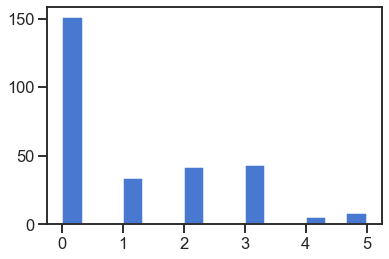

In [615]:
plt.hist(TM_obj.mask_stats['human']['mask_count'], bins=15);

In [616]:
TM_obj.mask_stats['human']

{'mask_count': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 5, 0, 0, 0, 5, 0, 3, 0, 3, 2, 3, 0, 5, 0, 3, 3, 2, 0, 3,
        3, 3, 3, 2, 0, 2, 5, 5, 4, 2, 2, 2, 2, 2, 2, 0, 2, 4, 2, 4, 0, 1,
        0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1,
        1, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0,
        0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 4, 4, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3, 3,
        3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2]),
 'mask_sum': 307,
 'mask_mean':

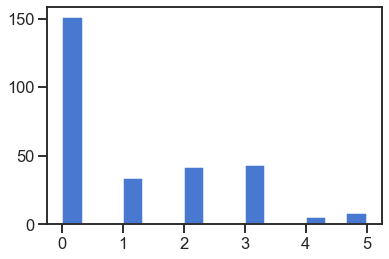

In [617]:
plt.hist(TM_obj.mask_stats['human']['mask_count'], bins=15);

In [576]:
TM_obj.mask_stats['human']

{'mask_count': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  5,  0,  0,  0,  5,  0,  4,  0,  4,
         0,  4,  0,  5,  0,  4,  4,  0,  0,  5,  5,  5,  5,  3,  0,  3,  5,
         5,  4,  2,  0,  0,  0,  0,  0,  0,  0,  4,  0,  4,  0,  0,  0,  0,
         0,  0,  5,  0,  0,  0,  5,  5,  0,  0,  0,  5,  5,  5,  5,  4,  0,
         5,  4,  2,  2,  2,  2,  3,  3,  2,  3,  3,  3,  2,  3,  3,  2,  3,
         3,  3,  0,  0,  3,  3,  3,  2,  3,  3,  3,  2,  2,  2,  2,  2,  0,
         0,  3,  3,  3,  0,  1,  1,  3,  5,  3,  5,  5,  1,  1,  0,  1,  1,
         1,  0,  0,  1,  1,  1,  1,  2,  4,  0,  4,  4,  4,  4,  4,  4,  3,
         0,  0,  3,  3,  3,  4,  4,  4,  4,  3,  3,  3,  3,  0,  0,  5,  5,
         2,  0,  0,  0,  4,  4,  0,  1,  0,  0,  1,  1,  1,  1,  0,  0,  0,
         1,  0,  4,  4,  4,  4,  1,  1,  0,  3,  0,  3,  3,  0,  0, 13, 13,
        13, 13,  0,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0

In [599]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database, sample_df, SWIPE_score_mat2, gap_penalty=3, extension_penalty=2, min_score_align=20, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=True)
# sample_df = align_obj.run_serial(dry_run=False, verbose=False, overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=4)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  100p2  100p1  100p3  100p4  85p4  85p2  85p3  85p1  70p3  70p2  70p1  55p1  55p3  55p4  70p4  40p1  40p2  55p2  25p1  40p4  25p2  10p1  25p4  10p3  10p2  25p3  0p2  40p3  0p4  0p1  10p4  0p3  0p_90m4  0p_90m1  0p_90m2  0p_90m3  common-seqs

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-10k.fastq.bz2,P1_R2_DSA-10k.fastq.bz2,944,38,902,940,99.576271,95.957447,931,866,930.174768,98.622881,93.100784,922.0,74.511931,25.488069,99.033298
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-10k.fastq.bz2,P2_R2_DSA-10k.fastq.bz2,673,14,648,662,98.365527,97.885196,663,622,662.581602,98.514116,93.875230,653.0,73.813170,26.186830,98.491704
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-10k.fastq.bz2,P3_R2_DSA-10k.fastq.bz2,709,35,666,701,98.871650,95.007133,692,633,691.544180,97.602257,91.534282,674.0,72.848665,27.151335,97.398844


In [618]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database_masked, sample_df, SWIPE_score_mat2, gap_penalty=3, extension_penalty=2, min_score_align=20, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=True)
# sample_df = align_obj.run_serial(dry_run=False, verbose=False, overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=4)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  100p1  100p3  100p2  100p4  85p4  85p2  85p3  70p3  85p1  70p1  70p2  55p1  55p2  55p4  40p1  70p4  40p2  55p3  40p3  25p3  25p4  10p1  25p1  25p2  10p4  10p2  10p3  40p4  0p2  0p1  0p3  0p4  0p_90m1  0p_90m3  0p_90m2  0p_90m4  common-seqs

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-10k.fastq.bz2,P1_R2_DSA-10k.fastq.bz2,944,38,902,940,99.576271,95.957447,931,866,930.174768,98.622881,93.100784,927.0,75.512406,24.487594,99.570354
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-10k.fastq.bz2,P2_R2_DSA-10k.fastq.bz2,673,14,648,662,98.365527,97.885196,663,622,662.581602,98.514116,93.875230,656.0,72.713415,27.286585,98.944193
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-10k.fastq.bz2,P3_R2_DSA-10k.fastq.bz2,709,35,666,701,98.871650,95.007133,692,633,691.544180,97.602257,91.534282,677.0,73.264402,26.735598,97.832370
